# CSE 572: Homework 4

This notebook provides a template and starting code to implement the Homework 3 assignment.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Problem statement

In Lab 17, we used statistical and distance-based approaches to detect anomalous changes in the daily closing prices of various stocks. The input data `stocks.csv` contains the historical closing prices of stocks for 3 large corporations (Microsoft, Ford Motor Company, and Bank of America). In the lab, we used anomaly detection techniques to detect anomalies in the changes in daily closing prices over the entire dataset (entire time period). 

In this homework, you will re-frame this problem to instead use techniques for novelty detection. Instead of scoring each sample based on its anomalousness compared to all other samples, you will score every sample based on its anomalousness compared to all previous samples in time. You will step through each record in order of time and at each step construct an updated model that will be used to score the new sample. Use the kth nearest neighbor approach used in Lab 17, but instead of using the distance to the 4th nearest neighbor as in Lab 17, use the average distance to the four nearest neighbors. 

## Load the dataset

In [ ]:
import pandas as pd

stocks = pd.read_csv('https://docs.google.com/uc?export=download&id=1UqHZmlfSoPDcZlTIr2TB6OadBhni9Kbv', header='infer')
stocks

stocks.index = stocks['Date']
stocks = stocks.drop(['Date'], axis=1)
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


We can compute the percentage of changes in the daily closing price of each stock as follows:
\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}} 
\end{equation}

where $x_t$ denotes the price of a stock on day $t$ and $x_{t-1}$ denotes the price on its previous day, $t-1$.

In [ ]:
import numpy as np

N, d = stocks.shape

delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                     columns=stocks.columns, 
                     index=stocks.iloc[1:].index)

delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


## Compute novelty scores

In this section, you will:
- Plot the novelty scores over time
- Identify which dates had the 5 highest novelty scores 

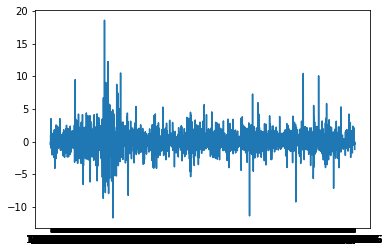

In [ ]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
plt.plot(delta.MSFT)

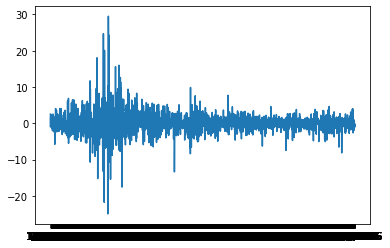

In [ ]:
import matplotlib.pyplot as plt
plt.plot(delta.F)

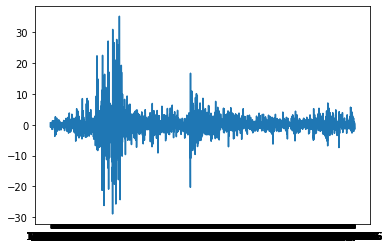

In [ ]:
import matplotlib.pyplot as plt
plt.plot(delta.BAC)

In [ ]:
from statistics import mean
mean=delta.mean()
cov=delta.cov()
print(mean)
print("------------------------------------------------")
print(cov)

MSFT    0.045003
F       0.061374
BAC     0.033351
dtype: float64
------------------------------------------------
          MSFT         F        BAC
MSFT  3.191674  2.136351   2.788870
F     2.136351  8.524944   4.997405
BAC   2.788870  4.997405  13.770761


In [ ]:
novel_score=[]
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance

for i in range(2517):
  if i==0:
    novel_score.append(0)
  if i>0 and i<5:
    k=i
    data=delta.iloc[:i]
   # data=np.array(data).reshape(-1,1)  
    nbrs = NearestNeighbors(n_neighbors=k, metric=distance.euclidean).fit(data.to_numpy())
    distances, indices = nbrs.kneighbors(delta.iloc[[i]].to_numpy())
    novel_score = np.append(novel_score ,np.mean(distances))


  elif i>=5:
     k=4
     data=delta.iloc[:i]
     #data=np.array(data).reshape(-1,1)
     nbrs = NearestNeighbors(n_neighbors=k, metric=distance.euclidean).fit(data.to_numpy())
     distances, indices = nbrs.kneighbors(delta.iloc[[i]].to_numpy())
     novel_score = np.append(novel_score ,np.mean(distances))

In [ ]:
anom = pd.DataFrame(novel_score, index=delta.index, columns=['Novelity score'])
result = pd.concat((delta, anom), axis=1)
result.nlargest(5, 'Novelity score')

,MSFT,F,BAC,Novelity score
Date,,,,
7/16/2008,4.244742,18.064516,22.408207,18.808495
10/13/2008,18.604651,20.100503,9.199808,18.749186
10/7/2008,-6.744279,-20.867209,-26.225949,18.043723
11/26/2008,2.501251,29.518072,4.256757,17.782658
9/30/2008,6.717317,24.700240,15.702479,16.361792


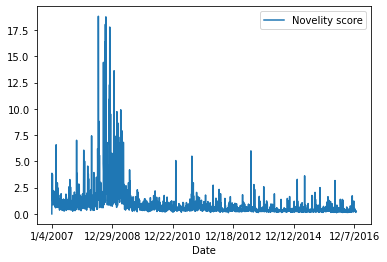

In [ ]:
import matplotlib.pyplot as plt
result.plot( y="Novelity score", kind="line")
plt.show()

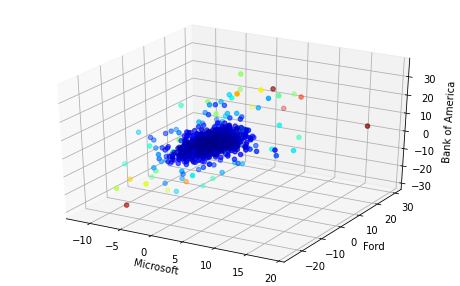

In [ ]:
# YOUR CODE HERE
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection='3d')
ax.scatter(delta.MSFT, delta.F, delta.BAC,c=novel_score,cmap='jet')
ax.set_xlabel('Microsoft')
ax.set_ylabel('Ford')
ax.set_zlabel('Bank of America')
plt.show()